In [1]:
# packages

# JAX
import jax.ops as jop
import jax.numpy as jnp
from jax import grad, vmap, hessian
from scipy.interpolate import griddata
#from jax.config import config; 
import jax
jax.config.update("jax_enable_x64", True)

# Numpy
import numpy as onp
from numpy import random 

# Plot
import matplotlib.pyplot as plt


We solve the following Burgers equation 

## General equation

\begin{equation*}
\begin{aligned}
& \partial_t (\phi S_p) + \nabla \cdot (K(x) \nabla \Phi_p ) = f, x \in [-1,1], t \in [0,1]\\
& \nabla \Phi_p(x,t) = \nabla p_p - \rho_p g \\
& f(\{S_p\}_{p=\{o,w,g\}})=0 \\
& u(0,x)=-\sin(\pi x)\\
& u(t,-1)=u(t,1)=0
\end{aligned}
\end{equation*}




## 1D time derivative equation

\begin{equation*}
\begin{aligned}
& \partial_t (\phi S) + \partial_x (K_x(x) \partial_x \Phi_p) = f , x \in [-1,1], t \in [0,1]\\
& \nabla \Phi_p(x,t) = \nabla p_p - \rho_p g \\
& f(\{S_p\}_{p=\{o,w,g\}})=0 \\
& u(0,x)=-\sin(\pi x)\\
& u(t,-1)=u(t,1)=0
\end{aligned}
\end{equation*}

The parameter $\nu$ controls the shock.

## 1D time derivative equation 1 Phase

\begin{equation*}
\begin{aligned}
& \partial_t p + \partial_x (K_x(x) \partial_x \Phi_p) = f , x \in [-1,1], t \in [0,1]\\
& \nabla \Phi_p(x,t) = \nabla p_p - \rho_p g \\
& S = \frac{p}{\phi} \\
& f(\{S_p\}_{p=\{o,w,g\}})=0 \\
& \partial_t p + \partial_x (K_x(x) \partial_x p) = f , x \in [-1,1], t \in [0,1]\\
& u(0,x)=-\sin(\pi x)\\
& u(t,-1)=u(t,1)=0
\end{aligned}
\end{equation*}

The parameter $\nu$ controls the shock.

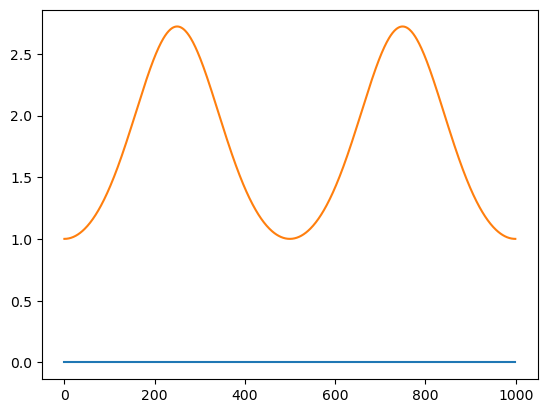

In [2]:
# fix random seeds, for generating reference solution & sampled points
# random.seed(20)

# we will use x=(x1,x2) as (t,x)

well_pos=[0.5]
inje_pos=[0.25,0.75]
# boundary condition

def K(x1):
    return jnp.exp(1.0*(jnp.sin(x1*2*jnp.pi)**2)+1e-3)
    #return 0.5

def u(x1,t1,w_p,i_p,amp=1e-5,x2=None):
    w_pot = jnp.sum(jnp.exp((-(x1-onp.expand_dims(onp.array(w_p),axis=1))**2)/amp),axis=0)
    i_pot = jnp.sum(jnp.exp((-(x1-onp.expand_dims(onp.array(i_p),axis=1))**2)/amp),axis=0)
    #return w_pot - i_pot + 0*(x1==0)
    return (w_pot - i_pot)*(t1==0)

plt.plot(u(x1=onp.linspace(0,1,1000),t1=1.0,w_p=well_pos,i_p=inje_pos))
plt.plot(K(x1=onp.linspace(0,1,1000)))

# right hand side
def f(x1, x2):
    return 0


\begin{equation*}
\begin{aligned}
R_i=((p)_i^{n+1}-(p)_i^{n}) + (K_x)_{i-\frac{1}{2}}^n \ (1 - kg) \frac{\Delta t^n}{h}((p)_{i}^{n}-(p)_{i-1}^{n})-(K_x)_{i+\frac{1}{2}}^n \ (1 - kg) \frac{\Delta t^n}{h}((p)_{i+1}^{n}-(p)_i^{n}) - \Delta t^n f \\ h, x \in [-1,1], t \in [0,1]\\
\end{aligned}
\end{equation*}

$$
\begin{equation*}
\begin{aligned}
D_{thk}=(1 - kg) \frac{\Delta t^n}{h}
\end{aligned}
\end{equation*}
$$

\begin{equation*}
\begin{aligned}
R_i=((p)_i^{n+1}-(p)_i^{n})  + (K_x)_{i-\frac{1}{2}}^n D_{thk}((p)_{i}^{n}-(p)_{i-1}^{n})-(K_x)_{i+\frac{1}{2}}^n \ D_{thk}((p)_{i+1}^{n}-(p)_i^{n}) - \Delta t^n f \\ h, x \in [-1,1], t \in [0,1]\\
\end{aligned}
\end{equation*}

\begin{equation*}
\begin{aligned}
J_{i,i}=\partial_{p_i} R_i= 1 + (K_x)_{i-\frac{1}{2}}^n D_{thk}+(K_x)_{i+\frac{1}{2}}^n D_{thk} \\ h, x \in [-1,1], t \in [0,1]\\
\end{aligned}
\end{equation*}

\begin{equation*}
\begin{aligned}
J_{i,i+1}=\partial_{p_{i+1}} R_i=-(K_x)_{i+\frac{1}{2}}^n \ D_{thk}(p)_{i+1}^{n}
\\ h, x \in [-1,1], t \in [0,1]\\
\end{aligned}
\end{equation*}

\begin{equation*}
\begin{aligned}
J_{i,i-1}=\partial_{p_{i-1}} R_i= -(K_x)_{i-\frac{1}{2}}^n D_{thk}(p)_{i-1}^{n} \\ h, x \in [-1,1], t \in [0,1]\\
\end{aligned}
\end{equation*}


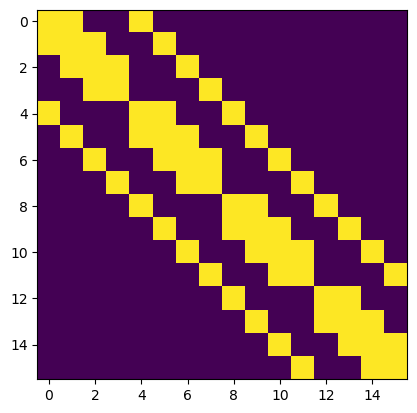

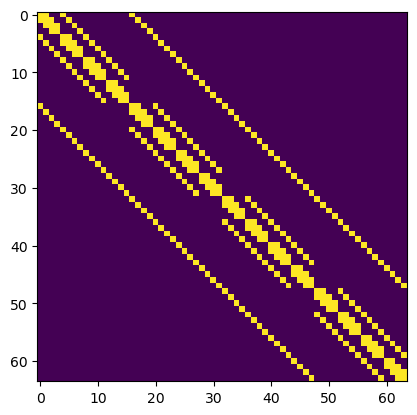

In [11]:
def get_neig(T,row, col):
    #row, col = 1, 1


    # Get immediate neighbors (up, down, left, right)
    # Check for boundary conditions to avoid index errors
    neighbors = []
    neighbors.append(T[row, col])
    if row > 0: # Up
        neighbors.append(T[row - 1, col])
    if row < T.shape[0] - 1: # Down
        neighbors.append(T[row + 1, col])
    if col > 0: # Left
        neighbors.append(T[row, col - 1])
    if col < T.shape[1] - 1: # Right
        neighbors.append(T[row, col + 1])
    return onp.array(neighbors)

def get_neig_3D(T,row, col, h):
    neighbors = []
    neighbors.append(T[row, col, h])
    if row > 0: # Up
        neighbors.append(T[row - 1, col,h])
    if row < T.shape[0] - 1: # Down
        neighbors.append(T[row + 1, col,h])
    if col > 0: # Left
        neighbors.append(T[row, col - 1,h])
    if col < T.shape[1] - 1: # Right
        neighbors.append(T[row, col + 1,h])
    if h > 0: # Left
        neighbors.append(T[row, col,h - 1])
    if h < T.shape[2] - 1: # Right
        neighbors.append(T[row, col,h + 1])
    return onp.array(neighbors)

size=4

T=onp.arange(size*size).reshape(size,size)
adjs=list(map(lambda ij:get_neig(T,*ij[::-1]),
         onp.stack(onp.meshgrid(onp.arange(size),onp.arange(size)),axis=-1).reshape(-1,2)
         ))

M=onp.zeros((size**2,size**2))
for adj,mc in zip(adjs,M):
    mc[adj]=1

plt.imshow(M)

T=onp.arange(size**3).reshape(size,size,size)
adjs=list(map(lambda ij:get_neig_3D(T,*ij[[1,0,2]]),
         onp.stack(onp.meshgrid(onp.arange(size),onp.arange(size),onp.arange(size)),axis=-1).reshape(-1,3)
         ))
M=onp.zeros((size**3,size**3))
for adj,mc in zip(adjs,M):
    mc[adj]=1

plt.figure()
plt.imshow(M)

In [12]:
# ELEMENTS

@jax.jit
def N1(xi,xj):
    return 0.25*(xi+1)*(xj+1)
@jax.jit
def N2(xi,xj):
    return 0.25*(xi-1)*(xj+1)
@jax.jit
def N3(xi,xj):
    return 0.25*(xi-1)*(xj-1)
@jax.jit
def N4(xi,xj):
    return 0.25*(xi+1)*(xj-1)


In [13]:
from jax import jacobian
drN1=grad(N1,argnums=(0,1))
drN2=grad(N2,argnums=(0,1))
drN3=grad(N3,argnums=(0,1))
drN4=grad(N4,argnums=(0,1))

D_op = (lambda xi,xj:jnp.array((drN1(xi,xj),drN2(xi,xj),drN3(xi,xj),drN4(xi,xj))))
print(D_op(0.0,0.0))

J_op = (lambda Xi,Xj,ei,ej: jnp.matmul(D_op(ei,ej).T,jnp.stack((Xi,Xj),axis=1)))

J_op(
    onp.array([1,4,6,8]),
    onp.array([1,4,6,8]),
    0.0,
    0.0
)

[[ 0.25  0.25]
 [ 0.25 -0.25]
 [-0.25 -0.25]
 [-0.25  0.25]]


Array([[-2.25, -2.25],
       [-0.25, -0.25]], dtype=float64)

\begin{equation*}
\begin{aligned}
R_i=((p)_i^{n+1}-(p)_i^{n}) + (K_x)_{i-\frac{1}{2}}^n \ (1 - kg) \frac{\Delta t^n}{h}((p)_{i}^{n}-(p)_{i-1}^{n})-(K_x)_{i+\frac{1}{2}}^n \ (1 - kg) \frac{\Delta t^n}{h}((p)_{i+1}^{n}-(p)_i^{n}) - \Delta t^n f \\ h, x \in [-1,1], t \in [0,1]\\
\end{aligned}
\end{equation*}

$$
\begin{equation*}
\begin{aligned}
D_{thk}=(1 - kg) \frac{\Delta t^n}{h}
\end{aligned}
\end{equation*}
$$

\begin{equation*}
\begin{aligned}
R_i=((p)_i^{n+1}-(p)_i^{n})  + (K_x)_{i-\frac{1}{2}}^n D_{thk}((p)_{i}^{n}-(p)_{i-1}^{n})-(K_x)_{i+\frac{1}{2}}^n \ D_{thk}((p)_{i+1}^{n}-(p)_i^{n}) - \Delta t^n f \\ h, x \in [-1,1], t \in [0,1]\\
\end{aligned}
\end{equation*}

\begin{equation*}
\begin{aligned}
J_{i,i}=\partial_{p_i} R_i= 1 + (K_x)_{i-\frac{1}{2}}^n D_{thk}+(K_x)_{i+\frac{1}{2}}^n D_{thk} \\ h, x \in [-1,1], t \in [0,1]\\
\end{aligned}
\end{equation*}

\begin{equation*}
\begin{aligned}
J_{i,i+1}=\partial_{p_{i+1}} R_i=-(K_x)_{i+\frac{1}{2}}^n \ D_{thk}(p)_{i+1}^{n}
\\ h, x \in [-1,1], t \in [0,1]\\
\end{aligned}
\end{equation*}

\begin{equation*}
\begin{aligned}
J_{i,i-1}=\partial_{p_{i-1}} R_i= -(K_x)_{i-\frac{1}{2}}^n D_{thk}(p)_{i-1}^{n} \\ h, x \in [-1,1], t \in [0,1]\\
\end{aligned}
\end{equation*}

In [3]:
from scipy.sparse import diags
import scipy
class FD_Darcy_flow_1D_1P(object):
    def __init__(self,N,p_init_range=(0,0.1),nsteps=10,dt=1e-4):
    # Create Matrix of space discrtization for solution
        self.N=N
        self.p_init_range=p_init_range
        self.nsteps=nsteps
        self.dt=dt
        L=1
        g=0.0
        k=1e-10
        self.x = onp.linspace(0, L, N+1)  # cell edges # N+1
        self.dx = L / N
        self.xc = (self.x[:-1] + self.x[1:]) * 0.5  # cell centers # N
        self.D=(dt/self.dx)*(1-k*g)
        self.K_c=K(self.x)

        self.iter_steps=100
        self.tol=1e-5
        self.t=0

        # Eval Jacobian
    def gen_p_init(self):
        return onp.random.uniform(*self.p_init_range,self.xc.shape).copy()

    def J_R_ii(self,x,xc,p):
        return (K(x[:-1])+K(x[1:]))*self.D-1
    def J_R_ijr(self,x,xc,p):
        return -1*K(x[1:-1])*self.D*p[:-1]
    def J_R_ijl(self,x,xc,p):
        return -1*K(x[1:-1])*self.D*p[1:]
        # Eval Residual
    def R(self,x,xc,p,p_1,t=0.0): # x[n], xc [n+1], p [n], p_1 [n]
        acc = (p - p_1)
        left_l = K(xc[:-1])*self.D*(p[:-1]-p[1:])
        # complete bc on bottom
        #left_l=onp.append(left_l,onp.array([0]))
        left_l=onp.append(onp.array([0]),left_l)
        left_r = K(xc[1:])*self.D*(p[1:]-p[:-1])
        #left_r=onp.append(onp.array([0]),left_r)
        left_r=onp.append(left_r,onp.array([0]))
        f=self.dt*u(xc,t,w_p=well_pos,i_p=inje_pos)*5.
        return acc + left_l -left_r - f
    
    def build_matrix(self,p):
        
        A=diags(
            [
                self.J_R_ijr(self.x,self.xc,p),
                self.J_R_ii(self.x,self.xc,p),
                self.J_R_ijl(self.x,self.xc,p),
            ],
            [1,0,-1],
            shape=(self.N**1,self.N**1)
            )
        return A
    def cg_step(self,A,p,p_1,t):
        A=self.build_matrix(p)
        dU=scipy.sparse.linalg.spsolve(A, -1*self.R(self.x,self.xc,p,p_1,t=t)[:,onp.newaxis])
        #new_p = p + 0.00001*dU
        new_p = p + 1e-1*dU
        return new_p,dU
    
    def cg_iter(self,p,p_1,t):
        A = self.build_matrix(p_1)
        for _ in range(self.iter_steps):
            new_p,dU = self.cg_step(A,p,p_1,t)
            conv_mearsure = onp.sum((dU)**2)
            p=new_p
            if conv_mearsure< self.tol:
                #print("by tol")
                return new_p
        #print("by max iters")
        return new_p
    
    def time_step(self,p_1,p):
        p = self.cg_iter(p,p_1, self.t)
        self.t=self.t+self.dt
        return p



S=FD_Darcy_flow_1D_1P(N=100,dt=1e-2)

In [4]:
p=onp.ones(S.gen_p_init().shape)*0.0
p_1=p.copy()



In [5]:

h_p=[p_1]
for t_i in range(100):
    new_p=S.time_step(p_1,p)
    h_p.append(new_p)
    p_1=new_p.copy()
    p=new_p.copy()

/tmp/ipykernel_78886/1993119289.py:60: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  dU=scipy.sparse.linalg.spsolve(A, -1*self.R(self.x,self.xc,p,p_1,t=t)[:,onp.newaxis])


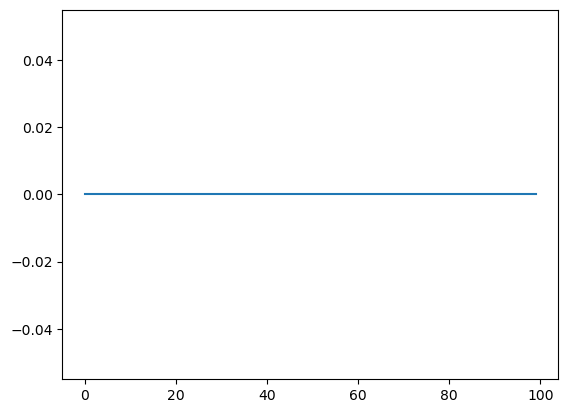

In [6]:
#%matplotlib inline
from IPython.display import HTML

import matplotlib.animation as animation
fig, ax = plt.subplots()
l, = ax.plot(onp.arange(0,100),h_p[0])
def animate(i):
    #l.plot(h_p[i],)
    l.set_ydata(h_p[i])
    #l.set_ydata(h_p[i])
    return l,

ani = animation.FuncAnimation(fig, animate, frames=len(h_p[:]),interval=50)


#HTML(ani.to_jshtml())
#HTML(ani.to_html5_video())
HTML(ani.to_jshtml())


(100,)
(101,)


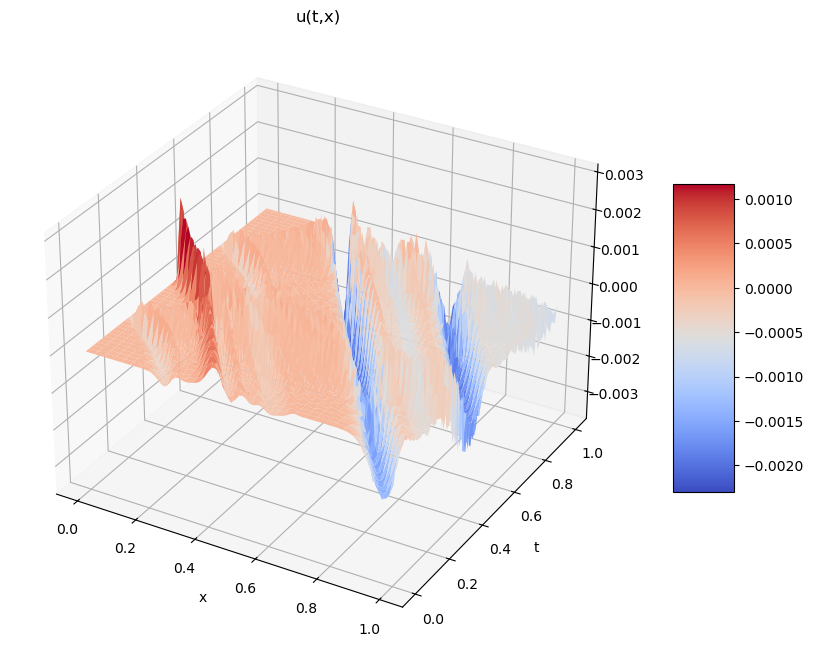

(100,)
(101,)


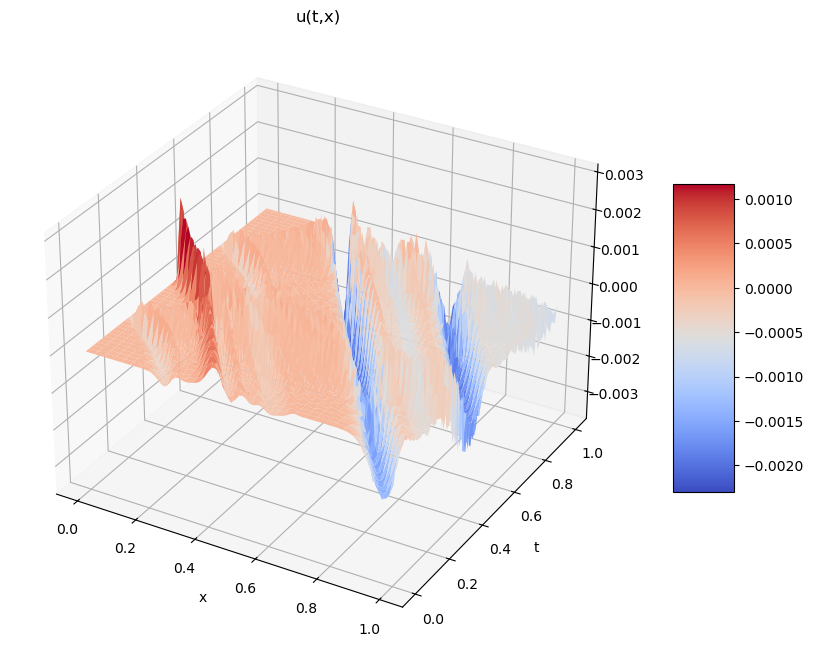

In [7]:
# plot the solution u(x,y), at the space-time domain or at a single time
    
def plot_u(num_pts1, num_pts2):
    xx = onp.linspace(0, 1, num_pts1)
    #yy = onp.linspace(0, 1, num_pts2)
    print(xx.shape)
    yy = onp.arange(0, num_pts2)*1e-2
    print(yy.shape)
    XX, YY = onp.meshgrid(xx, yy)

    # vectorized (x,y) coordinates
    XXv = onp.array(XX.flatten())
    YYv = onp.array(YY.flatten())

    #ZZ_u = vmap(u_true)(XXv, YYv)
    #ZZ_u = ZZ_u.reshape(num_pts2,num_pts1)
    ZZ_u = onp.array(h_p) # [t x]
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')
    u_surf=ax.plot_surface(YY, XX, ZZ_u, cmap=plt.cm.coolwarm)
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('u(t,x)')
    
    fig.colorbar(u_surf, shrink= 0.5, aspect = 5)
    plt.show()
    return XXv,YYv,ZZ_u
    
def plot_u_time_t(t, num_pts):
    xx = t
    yy = onp.linspace(-1, 1, num_pts)
    XX, YY = onp.meshgrid(xx, yy)

    # vectorized (x,y) coordinates
    XXv = onp.array(XX.flatten())
    YYv = onp.array(YY.flatten())

    #ZZ_u = vmap(u_true)(XXv, YYv)
    ZZ_u = onp.array(h_p)
    
    fig = plt.figure(figsize=(12,8))
    plt.plot(yy, ZZ_u)
    plt.xlabel('x')
    plt.title('u(t,x) at time %f' %t)
    plt.show()
    
# test
# plot the figure
XXv,YYv,ZZ_u = plot_u(100,101)
XXv_g,YYv_g,ZZ_u_g = plot_u(100,101)

In [8]:
#XXv.shape
#YYv.shape
ZZ_u.shape

(101, 100)

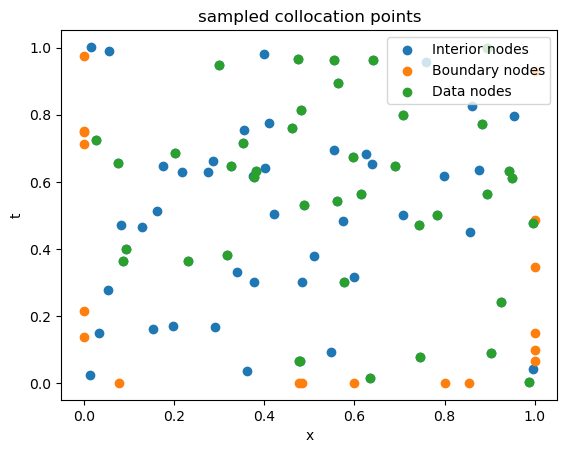

In [19]:
# sampled collocation points

def sample_points(N_domain, N_boundary,N_data): # [t x]
    # interior nodes
    x_min = 0
    x_max = 1
    t_min = 0
    t_max = 101*1e-2
    X_domain = onp.random.uniform(x_min, x_max, (N_domain, 2))
    X_domain[:,1] = X_domain[:,1]
    X_domain[:,0] = t_max*(X_domain[:,0]/x_max)
    X_boundary = onp.zeros((N_boundary, 2))

    # generate random boundary points on the faces of the domain 

    # bottom face
    X_boundary[:int(N_boundary/3), 1] = onp.random.uniform(x_min, x_max, int(N_boundary/3))
    # right face
    X_boundary[int(N_boundary/3):2*int(N_boundary/3), 0] = onp.random.uniform(t_min, t_max, int(N_boundary/3))
    X_boundary[int(N_boundary/3):2*int(N_boundary/3), 1] = x_max
    # left face
    X_boundary[2*int(N_boundary/3):, 0] = onp.random.uniform(t_min, t_max, int(N_boundary/3))
    X_boundary[2*int(N_boundary/3):, 1] = x_min
    data_index = onp.array(range(N_data))
    
    return X_domain.astype(float), X_boundary.astype(float), data_index

N_domain_tot = 80
N_boundary_tot = 18
N_data_tot = 40
X_domain_tot, X_boundary_tot, data_index_tot = sample_points(N_domain_tot, N_boundary_tot,N_data_tot) # [M 2] [dM 2]

fig, ax = plt.subplots()
ax.scatter(X_domain_tot[range(N_domain_tot), 1], X_domain_tot[range(N_domain_tot), 0], label='Interior nodes')
ax.scatter(X_boundary_tot[range(N_boundary_tot), 1], X_boundary_tot[range(N_boundary_tot), 0], label='Boundary nodes')
ax.scatter(X_domain_tot[data_index_tot, 1], X_domain_tot[data_index_tot, 0], label='Data nodes')
ax.legend(loc="upper right")
ax.set_xlabel('x')
ax.set_ylabel('t')
plt.title('sampled collocation points')
plt.show()

Now, let us define kernels / covariance functions that are used to solve the PDEs

We use kernels for both time and space as:
$$k(x,y) = \exp(-\alpha_1^2(x_1-y_1)^2-\alpha_2^2(x_2-y_2)^2)$$

where:
$\alpha_1$: scale parameter in time

$\alpha_2$: scale parameter in space

## 1D time derivative equation 1 Phase

\begin{equation*}
\begin{aligned}
& \partial_t p + \partial_x (K_x(x) \partial_x \Phi_p) = f , x \in [-1,1], t \in [0,1]\\
& \nabla \Phi_p(x,t) = \nabla p_p - \rho_p g \\
& S = \frac{p}{\phi} \\
& f(\{S_p\}_{p=\{o,w,g\}})=0 \\
& \partial_t p + \partial_x (K_x(x) \partial_x p) = f , x \in [-1,1], t \in [0,1]\\
& u(0,x)=-\sin(\pi x)\\
& u(t,-1)=u(t,1)=0
\end{aligned}
\end{equation*}

The parameter $\nu$ controls the shock.

### DOFs

$$t: t_1,t_2$$
$$x: x_1,x_2$$

### Equation

\begin{equation*}
\begin{aligned}
\partial_t p(x,t) - \partial_x (\exp(k(x))  \partial_x p(x,t)) = f \\
\partial_t p(x,t) - \exp(k(x))(\partial_x k(x) \partial_x p(x,t) + \partial_{xx} p(x,t))) = f
\end{aligned}
\end{equation*}


# Operators

## Forward: $p$

\begin{equation*}
\begin{aligned}
L_1: p \\
L_2: \partial_t p \\
L_3: \partial_x p \\
L_4: \partial_{xx} p \\
\end{aligned}
\end{equation*}

## Forward: $k$

\begin{equation*}
\begin{aligned}
\tilde{L}_1: k(x) \\
\tilde{L}_2: \partial_x k(x) \\
\end{aligned}
\end{equation*}

In [20]:

# kernels and derivatives

def kappa(t1, x1, t2, x2, sigma):
    # x,y are 2D input row vectors
    
    scale_t = sigma[0]
    scale_x = sigma[1]
    
    r = (scale_t*(t1-t2))**2+(scale_x*(x1-x2))**2

    return jnp.exp(-r)


def D_t1_kappa(t1, x1, t2, x2, sigma):
    val = grad(kappa,0)(t1, x1, t2, x2, sigma)
    return val

def D_x1_kappa(t1, x1, t2, x2, sigma):
    val = grad(kappa,1)(t1, x1, t2, x2, sigma)
    return val

def DD_x1_kappa(t1, x1, t2, x2, sigma):
    val = grad(grad(kappa,1),1)(t1, x1, t2, x2, sigma)
    return val

def D_t2_kappa(t1, x1, t2, x2, sigma):
    val = grad(kappa,2)(t1, x1, t2, x2, sigma)
    return val

def D_x2_kappa(t1, x1, t2, x2, sigma):
    val = grad(kappa,3)(t1, x1, t2, x2, sigma)
    return val

def DD_x2_kappa(t1, x1, t2, x2, sigma):
    val = grad(grad(kappa,3),3)(t1, x1, t2, x2, sigma)
    return val

def D_t1_D_t2_kappa(t1, x1, t2, x2, sigma):
    val = grad(grad(kappa,0),2)(t1, x1, t2, x2, sigma)
    return val

def D_t1_D_x2_kappa(t1, x1, t2, x2, sigma):
    val = grad(grad(kappa,0),3)(t1, x1, t2, x2, sigma)
    return val

def D_t1_DD_x2_kappa(t1, x1, t2, x2, sigma):
    val = grad(grad(grad(kappa,0),3),3)(t1, x1, t2, x2, sigma)
    return val

def D_x1_D_x2_kappa(t1, x1, t2, x2, sigma):
    val = grad(grad(kappa,1),3)(t1, x1, t2, x2, sigma)
    return val

def D_x1_DD_x2_kappa(t1, x1, t2, x2, sigma):
    val = grad(grad(grad(kappa,1),3),3)(t1, x1, t2, x2, sigma)
    return val

def DD_x1_DD_x2_kappa(t1, x1, t2, x2, sigma):
    val = grad(grad(grad(grad(kappa,1),1),3),3)(t1, x1, t2, x2, sigma)
    return val


Forward: $p(x_i), p_t(x_i), p_x(x_i), p_{xx}(x_i)$

IP: $k(x_i), k_x(x_i)$

$[v_1,v_2,v_3,v_0,v_b]$, where

$v_0, v_1, v_2, v_3$  $\leftarrow u(x_i), u_t(x_i), u_x(x_i), u_{xx}(x_i)$

$v_b \leftarrow \partial u(x_i)$

$[w_0,w_1]$, where

$w_0,w_1$  $\leftarrow k(x_i), k_x(x_i)$

The Gram matrix $\Theta$ is then determined by this organization. Next code block is to construct this matrix.


In [21]:
# vectorized construction of the Gram matrix Theta
def assembly_Theta(X_domain, X_boundary, nugget, set_sigma): # [M 2] [dM 2]
    """
    parameter sigma is set to be  [ 3 20]
    interior + boundary points coordinates
    (1201,)
    interior v.s. interior interaction (used for construct kernel matrix)
    (1000, 1000)
    """
    
    N_domain = X_domain.shape[0] # [M 2]
    N_boundary = X_boundary.shape[0] # [dM 2]
    Theta_u = jnp.zeros((4*N_domain + N_boundary, 4*N_domain + N_boundary))
    Theta_a = jnp.zeros((2*N_domain, 2*N_domain))

    # auxiliary variables to make things readable
    # interior points coordinates
    Xd0=X_domain[:N_domain, 0] # [M]
    Xd1=X_domain[:N_domain, 1] # [M]
    
    # interior + boundary points coordinates
    Xdb0=jnp.concatenate([Xd0, X_boundary[:N_boundary, 0]]) # [M+dM]
    print("interior + boundary points coordinates") # (1201,)
    print(Xdb0.shape)
    Xdb1=jnp.concatenate([Xd1, X_boundary[:N_boundary, 1]]) # [M+dM]

    # interior v.s. interior interaction (used for construct kernel matrix)
    XXdd0=jnp.transpose(jnp.tile(Xd0,(N_domain,1))) # [M M]
    print("interior v.s. interior interaction (used for construct kernel matrix)")
    print(XXdd0.shape)
    XXdd1=jnp.transpose(jnp.tile(Xd1,(N_domain,1))) # [M M]

    # interior+boudary v.s. interior+bpundary interaction
    XXdbdb0=jnp.transpose(jnp.tile(Xdb0,(N_domain+N_boundary,1))) # [M+dM M+dM]
    XXdbdb1=jnp.transpose(jnp.tile(Xdb1,(N_domain+N_boundary,1))) # [M+dM M+dM]

    # interior v.s. interior+boundary interaction
    XXddb0=jnp.transpose(jnp.tile(Xd0,(N_domain+N_boundary,1))) # [M+dM M]
    XXddb1=jnp.transpose(jnp.tile(Xd1,(N_domain+N_boundary,1))) # [M+dM M]
    XXddb0_2=jnp.tile(Xdb0,(N_domain,1)) # [M M+dM]
    XXddb1_2=jnp.tile(Xdb1,(N_domain,1)) # [M M+dM]

    # Construct kernel matrix
    # interior v.s. interior 
    val = vmap(lambda t1, x1, t2, x2: D_t1_D_t2_kappa(t1, x1, t2, x2, set_sigma))(
        XXdd0.flatten(),XXdd1.flatten(),jnp.transpose(XXdd0).flatten(),jnp.transpose(XXdd1).flatten()
    )
    Theta_u = Theta_u.at[0:N_domain, 0:N_domain].set(jnp.reshape(val, (N_domain, N_domain)))
    
    val = vmap(lambda t1, x1, t2, x2: D_t1_D_x2_kappa(t1, x1, t2, x2, set_sigma))(
        XXdd0.flatten(),XXdd1.flatten(),jnp.transpose(XXdd0).flatten(),jnp.transpose(XXdd1).flatten()
    )
    Theta_u = Theta_u.at[0:N_domain, N_domain:2*N_domain].set(jnp.reshape(val, (N_domain, N_domain)))
    Theta_u = Theta_u.at[N_domain:2*N_domain, 0:N_domain].set(jnp.transpose(jnp.reshape(val, (N_domain, N_domain))))
    
    val = vmap(lambda t1, x1, t2, x2: D_t1_DD_x2_kappa(t1, x1, t2, x2, set_sigma))(
        XXdd0.flatten(),XXdd1.flatten(),jnp.transpose(XXdd0).flatten(),jnp.transpose(XXdd1).flatten()
    )
    #Theta_u = jop.index_update(Theta_u, jop.index[0:N_domain, 2*N_domain:3*N_domain], jnp.reshape(val, (N_domain, N_domain)))
    Theta_u = Theta_u.at[0:N_domain, 2*N_domain:3*N_domain].set(jnp.reshape(val, (N_domain, N_domain)))
    #Theta_u = jop.index_update(Theta_u, jop.index[2*N_domain:3*N_domain, 0:N_domain], jnp.transpose(jnp.reshape(val, (N_domain, N_domain))))
    Theta_u = Theta_u.at[2*N_domain:3*N_domain, 0:N_domain].set(jnp.transpose(jnp.reshape(val, (N_domain, N_domain))))
    
    val = vmap(lambda t1, x1, t2, x2: D_x1_D_x2_kappa(t1, x1, t2, x2, set_sigma))(
        XXdd0.flatten(),XXdd1.flatten(),jnp.transpose(XXdd0).flatten(),jnp.transpose(XXdd1).flatten()
    )
    #Theta_u = jop.index_update(Theta_u, jop.index[N_domain:2*N_domain, N_domain:2*N_domain], jnp.reshape(val, (N_domain, N_domain)))
    Theta_u = Theta_u.at[N_domain:2*N_domain, N_domain:2*N_domain].set(jnp.reshape(val, (N_domain, N_domain)))
    
    val = vmap(lambda t1, x1, t2, x2: D_x1_DD_x2_kappa(t1, x1, t2, x2, set_sigma))(
        XXdd0.flatten(),XXdd1.flatten(),jnp.transpose(XXdd0).flatten(),jnp.transpose(XXdd1).flatten()
    )
    #Theta_u = jop.index_update(Theta_u, jop.index[N_domain:2*N_domain, 2*N_domain:3*N_domain], jnp.reshape(val, (N_domain, N_domain)))
    Theta_u = Theta_u.at[N_domain:2*N_domain, 2*N_domain:3*N_domain].set(jnp.reshape(val, (N_domain, N_domain)))
    #Theta_u = jop.index_update(Theta_u, jop.index[2*N_domain:3*N_domain, N_domain:2*N_domain], jnp.transpose(jnp.reshape(val, (N_domain, N_domain))))
    Theta_u = Theta_u.at[2*N_domain:3*N_domain, N_domain:2*N_domain].set(jnp.transpose(jnp.reshape(val, (N_domain, N_domain))))
    
    val = vmap(lambda t1, x1, t2, x2: DD_x1_DD_x2_kappa(t1, x1, t2, x2, set_sigma))(
        XXdd0.flatten(),XXdd1.flatten(),jnp.transpose(XXdd0).flatten(),jnp.transpose(XXdd1).flatten()
    )
    #Theta_u = jop.index_update(Theta_u, jop.index[2*N_domain:3*N_domain, 2*N_domain:3*N_domain], jnp.reshape(val, (N_domain, N_domain)))
    Theta_u = Theta_u.at[2*N_domain:3*N_domain, 2*N_domain:3*N_domain].set(jnp.reshape(val, (N_domain, N_domain)))
    
    # interior+boundary v.s. interior+boundary
    val = vmap(lambda t1, x1, t2, x2: kappa(t1, x1, t2, x2, set_sigma))(
        XXdbdb0.flatten(),XXdbdb1.flatten(),jnp.transpose(XXdbdb0).flatten(),jnp.transpose(XXdbdb1).flatten()
    )
    #Theta_u = jop.index_update(Theta_u, jop.index[3*N_domain:, 3*N_domain:], jnp.reshape(val, (N_domain+N_boundary, N_domain+N_boundary)))
    Theta_u = Theta_u.at[3*N_domain:, 3*N_domain:].set(jnp.reshape(val, (N_domain+N_boundary, N_domain+N_boundary)))
    
    # interior v.s. interior+boundary
    val = vmap(lambda t1, x1, t2, x2: D_t1_kappa(t1, x1, t2, x2, set_sigma))(
        XXddb0.flatten(),XXddb1.flatten(),XXddb0_2.flatten(),XXddb1_2.flatten()
    )

    Theta_u = Theta_u.at[0:N_domain, 3*N_domain:].set(jnp.reshape(val, (N_domain, N_domain+N_boundary)))
    Theta_u = Theta_u.at[3*N_domain:, 0:N_domain].set(jnp.transpose(jnp.reshape(val, (N_domain, N_domain+N_boundary))))
    
    val = vmap(lambda t1, x1, t2, x2: D_x1_kappa(t1, x1, t2, x2, set_sigma))(
        XXddb0.flatten(),XXddb1.flatten(),XXddb0_2.flatten(),XXddb1_2.flatten()
    )

    Theta_u = Theta_u.at[N_domain:2*N_domain, 3*N_domain:].set(jnp.reshape(val, (N_domain, N_domain+N_boundary)))
    Theta_u = Theta_u.at[3*N_domain:, N_domain:2*N_domain].set(jnp.transpose(onp.reshape(val, (N_domain, N_domain+N_boundary))))
    
    val = vmap(lambda t1, x1, t2, x2: DD_x1_kappa(t1, x1, t2, x2, set_sigma))(
        XXddb0.flatten(),XXddb1.flatten(),XXddb0_2.flatten(),XXddb1_2.flatten()
        )
    
    Theta_u = Theta_u.at[2*N_domain:3*N_domain, 3*N_domain:].set(jnp.reshape(val, (N_domain, N_domain+N_boundary)))
    Theta_u = Theta_u.at[3*N_domain:, 2*N_domain:3*N_domain].set(jnp.transpose(jnp.reshape(val, (N_domain, N_domain+N_boundary))))
    
    #Theta_u = Theta_u.at[2*N_domain:3*N_domain, 3*N_domain:].set(jnp.reshape(val, (N_domain, N_domain+N_boundary)))

    Theta_a = Theta_a.at[0:N_domain, 0:N_domain].set(Theta_u[N_domain:2*N_domain, N_domain:2*N_domain])
    Theta_a = Theta_a.at[N_domain:2*N_domain, N_domain:2*N_domain].set(Theta_u[3*N_domain:4*N_domain, 3*N_domain:4*N_domain])
    Theta_a = Theta_a.at[0:N_domain, N_domain:].set(Theta_u[N_domain:2*N_domain, 3*N_domain:4*N_domain])
    Theta_a = Theta_a.at[N_domain:, 0:N_domain].set(Theta_u[3*N_domain:4*N_domain, N_domain:2*N_domain])
    
    # calculate trace
    # Theta_u
    trace1_u = jnp.trace(Theta_u[:N_domain, :N_domain])
    trace2_u = jnp.trace(Theta_u[N_domain:2*N_domain, N_domain:2*N_domain])
    trace3_u = jnp.trace(Theta_u[2*N_domain:3*N_domain, 2*N_domain:3*N_domain])
    trace4_u = jnp.trace(Theta_u[3*N_domain:, 3*N_domain:])
    ratio_u = [trace1_u/trace4_u, trace2_u/trace4_u, trace3_u/trace4_u]

    # Theta_a
    trace1_a = jnp.trace(Theta_a[:N_domain, :N_domain])
    trace2_a = jnp.trace(Theta_a[N_domain:2*N_domain, N_domain:2*N_domain])
    ratio_a = [trace1_a/trace2_a]
    
    temp=jnp.concatenate(
        (
            ratio_u[0]*jnp.ones((1,N_domain)),
            ratio_u[1]*jnp.ones((1,N_domain)),
            ratio_u[2]*jnp.ones((1,N_domain)),
            jnp.ones((1,N_domain+N_boundary))
        ), axis=1)
    Theta_u = Theta_u + nugget*jnp.diag(temp[0]) 
    L_u = jnp.linalg.cholesky(Theta_u)

    temp=jnp.concatenate(
        (
            ratio_a[0]*jnp.ones((1,N_domain)),
            jnp.ones((1,N_domain))
        ), axis=1)
    Theta_a = Theta_a + nugget*jnp.diag(temp[0]) 
    L_a = jnp.linalg.cholesky(Theta_a)
    
    return L_u, L_a, ratio_u, ratio_a

In the above, we added trace-adaptive nugget terms to regularize the Gram matrix
\begin{equation*}
\Theta_{\lambda} = \Theta +
\text{nugget}\times\begin{bmatrix}
\lambda_1 I & 0 & 0 & 0\\
0 & \lambda_2 I & 0 & 0\\
0 & 0 & \lambda_3I & 0 \\
0 & 0 & 0 & I
\end{bmatrix}
\end{equation*}
where $\lambda_1, \lambda_2, \lambda_3$ are selected to be the trace ratios of the orginal Gram matrix

In [22]:
set_sigma = [0.2, 0.2]
set_nugget = 1e-5
L_u, L_a, ratio_u, ratio_a = assembly_Theta(X_domain_tot, X_boundary_tot, set_nugget, set_sigma)
print('trace ratio (u part) =', ratio_u)
print('trace ratio (a part) =', ratio_a)
print('observation: the trace ratio is large, and our adaptive nugget term is effective')

interior + boundary points coordinates
(98,)
interior v.s. interior interaction (used for construct kernel matrix)
(80, 80)
trace ratio (u part) = [Array(0.06530612, dtype=float64), Array(0.06530612, dtype=float64), Array(0.01567347, dtype=float64)]
trace ratio (a part) = [Array(0.08, dtype=float64)]
observation: the trace ratio is large, and our adaptive nugget term is effective


Then, we solve the following optimization problem:

\begin{equation*}
\begin{aligned}
\min&\quad   [v_1,v_2,v_3,v_0,v_b]\Theta_{u}^{-1} [v_1,v_2,v_3,v_0,v_b]^T + \frac{1}{\gamma^2}|u-o|^2 +[w_1,w_0]\Theta_{a}^{-1}[w_1,w_0]^T\\
  \text{s.t.}&\quad v_1 - \exp(w_0)(w_1 v_2 + v_3) = f \text{ and } v_b = \text{boundary data}
\end{aligned}
\end{equation*}

Here, $v_0, v_1, v_2, v_3$ represent the interior nodal values of $u(x_i), u_t(x_i), u_x(x_i), u_{xx}(x_i)$, respectively.

In [23]:

# loss functions

def J(wv, rhs_f, bdy_g, data_u, L_u, L_a, noise):
    N_domain = rhs_f.shape[0]
    N_data = data_u.shape[0]
    
    w0 = wv[0:N_domain]
    w1 = wv[N_domain:2*N_domain]
    
    v0 = wv[2*N_domain:3*N_domain]
    v1 = wv[3*N_domain:4*N_domain]
    v2 = wv[4*N_domain:5*N_domain]
    v3 = -v1*w1+(-rhs_f)*jnp.exp(-w0)
    
    w_all = jnp.concatenate((w1,w0), axis=0)
    v_all = jnp.concatenate((v1,v2,v3,v0,bdy_g), axis=0)
    temp_a = jnp.linalg.solve(L_a,w_all)
    temp_u = jnp.linalg.solve(L_u,v_all)
    return jnp.dot(temp_a, temp_a) + jnp.dot(temp_u, temp_u) + (1/noise**2)*jnp.sum((v0[:N_data]-data_u)**2)

# gradient of loss functions
grad_J = grad(J)

def GN_J(wv, rhs_f, bdy_g, data_u, L_u, L_a, noise, wv_old):
    N_domain = rhs_f.shape[0]
    N_data = data_u.shape[0]
    
    w0_old = wv_old[0:N_domain]
    w1_old = wv_old[N_domain:2*N_domain]
    v0_old = wv_old[2*N_domain:3*N_domain]
    v1_old = wv_old[3*N_domain:4*N_domain]
    v2_old = wv_old[4*N_domain:5*N_domain] 

    w0 = wv[0:N_domain]
    w1 = wv[N_domain:2*N_domain]
    v0 = wv[2*N_domain:3*N_domain]
    v1 = wv[3*N_domain:4*N_domain]
    v2 = wv[4*N_domain:5*N_domain]
    v3 = (-rhs_f)*(-jnp.exp(-w0_old))*w0 + (-v1_old)*w1 + (-w1_old)*v1
    
    w_all = jnp.concatenate((w1,w0), axis=0)
    v_all = jnp.concatenate((v1,v2,v3,v0,bdy_g), axis=0)
    
    temp_a = jnp.linalg.solve(L_a,w_all)
    temp_u = jnp.linalg.solve(L_u,v_all)
    return jnp.dot(temp_a, temp_a) + jnp.dot(temp_u, temp_u) + (1/noise**2)*jnp.sum((v0[:N_data]-data_u)**2)

Hessian_GN = hessian(GN_J)
 # XXv_g,YYv_g,ZZ_u_g
def get_data_u(x,y):
    return griddata((XXv_g,YYv_g), onp.array(h_p).flatten(), (x,y), method='linear')

# solve PDEs
def pde_solver(X_domain, X_boundary, data_index, nugget, max_iter, step_size, initial_sol, set_sigma, noise):
    rhs_f = vmap(f)(X_domain[:,0], X_domain[:,1])
    # u(xc,t,w_p=well_pos,i_p=inje_pos)
    bdy_g = vmap(lambda x,t:u(x,t,w_p=well_pos,i_p=inje_pos))(X_boundary[:,0], X_boundary[:,1]).reshape(-1,)
    # data_u
    data_u = onp.vectorize(get_data_u)(X_domain[data_index,0], X_domain[data_index,1])
    data_u = data_u + noise*random.normal(0, 1.0, onp.shape(data_u)[0])
    
    L_u, L_a, ratio_u, ratio_a = assembly_Theta(X_domain_tot, X_boundary_tot, set_nugget, set_sigma)

    sol = initial_sol
    J_hist = [] # history of loss function values
    J_now = J(sol,rhs_f,bdy_g,data_u,L_u,L_a, noise)
    J_hist.append(J_now)
    
    print('iter = 0', 'J =', J_now) # print out history
    
    for iter_step in range(1, max_iter+1):
        temp = onp.linalg.solve(Hessian_GN(sol,rhs_f,bdy_g,data_u,L_u,L_a,noise, sol), grad_J(sol,rhs_f,bdy_g,data_u,L_u,L_a,noise))
        sol = sol - step_size*temp  
        
        J_now = J(sol,rhs_f,bdy_g,data_u,L_u,L_a,noise)
        J_hist.append(J_now)
        # print out history
        print('iter = ', iter_step, 'Gauss-Newton step size =', step_size, ' J = ', J_now)               
    return sol, J_hist




In [24]:
# ----- test pde solution

#nugget=1e-5
#max_iter=12
#initial_sol=random.normal(0, 1.0, (3*N_domain_tot))
#set_sigma=jnp.array([3,20])
#print('parameter sigma is set to be ', set_sigma)
#sol, J_hist, J_final, L = pde_solver(X_domain_tot, X_boundary_tot, nugget, max_iter, initial_sol, set_sigma, 1)
#                                     X_domain, X_boundary, data_index, nugget, max_iter, step_size, initial_sol, set_sigma, noise
set_sigma = [50,20]
set_nugget = 1e-5
noise = 1e-7
initial_sol = random.normal(0, 1.0, (5*N_domain_tot))
max_iter = 10
step_size = 1
sol, J_hist = pde_solver(X_domain_tot, X_boundary_tot, data_index_tot, set_nugget, max_iter, step_size, initial_sol, set_sigma, noise)


interior + boundary points coordinates
(98,)
interior v.s. interior interaction (used for construct kernel matrix)
(80, 80)
iter = 0 J = 4424298168057775.0
iter =  1 Gauss-Newton step size = 1  J =  5.130772734720364
iter =  2 Gauss-Newton step size = 1  J =  1.470848434491365
iter =  3 Gauss-Newton step size = 1  J =  1.4700269594310675
iter =  4 Gauss-Newton step size = 1  J =  1.470026877848422
iter =  5 Gauss-Newton step size = 1  J =  1.4700268768834757
iter =  6 Gauss-Newton step size = 1  J =  1.4700268768720248
iter =  7 Gauss-Newton step size = 1  J =  1.4700268768718887
iter =  8 Gauss-Newton step size = 1  J =  1.470026876871887
iter =  9 Gauss-Newton step size = 1  J =  1.4700268768718867
iter =  10 Gauss-Newton step size = 1  J =  1.4700268768718872


In [25]:
def construct_inpTheta_a(X_test, X_domain, X_boundary):
    N_test = X_test.shape[0]
    N_domain = X_domain.shape[0]
    N_boundary = X_boundary.shape[0]
    inpTheta = onp.zeros((N_test, 2*N_domain))

    # auxiliary variables to make things readable
    
    # X_test coordinates
    Xt0=X_test[:,0]
    Xt1=X_test[:,1]
    
    # interior points coordinates
    Xd0=X_domain[:N_domain, 0]
    Xd1=X_domain[:N_domain, 1]
    
    # interior + boundary points coordinates
    Xdb0=onp.concatenate([Xd0, X_boundary[:N_boundary, 0]])
    Xdb1=onp.concatenate([Xd1, X_boundary[:N_boundary, 1]])
    
    # test v.s. interior
    XXtd0=onp.transpose(onp.tile(Xt0,(N_domain,1)))
    XXtd1=onp.transpose(onp.tile(Xt1,(N_domain,1)))
    XXtd0_2=onp.tile(Xd0,(N_test,1))
    XXtd1_2=onp.tile(Xd1,(N_test,1))
    
    # test v.s. interior + boundary
    XXtdb0=onp.transpose(onp.tile(Xt0,(N_domain+N_boundary,1)))
    XXtdb1=onp.transpose(onp.tile(Xt1,(N_domain+N_boundary,1)))
    XXtdb0_2=onp.tile(Xdb0,(N_test,1))
    XXtdb1_2=onp.tile(Xdb1,(N_test,1))
    
    # constructing Theta matrix
    val = vmap(lambda x1,x2,y1,y2: D_x2_kappa(x1, x2, y1, y2, set_sigma))(XXtd0.flatten(),XXtd1.flatten(),XXtd0_2.flatten(),XXtd1_2.flatten())
    inpTheta[:,:N_domain] = onp.reshape(val, (N_test, N_domain))
    
    val = vmap(lambda x1,x2,y1,y2: kappa(x1, x2, y1, y2, set_sigma))(XXtd0.flatten(),XXtd1.flatten(),XXtd0_2.flatten(),XXtd1_2.flatten())
    inpTheta[:,N_domain:] = onp.reshape(val, (N_test, N_domain))
    
    return inpTheta


def extend_solution_a(X_test, X_domain, X_boundary, L_a, v):
        
    inp_Theta = construct_inpTheta_a(X_test, X_domain, X_boundary)
    aux = onp.linalg.solve(onp.transpose(L_a),onp.linalg.solve(L_a,v))
    
    extended_a = onp.matmul(inp_Theta,aux)
    return extended_a

# use kernel interpolation to extend the solution at test points

def construct_inpTheta_u(X_test, X_domain, X_boundary):
    N_test = X_test.shape[0]
    N_domain = X_domain.shape[0]
    N_boundary = X_boundary.shape[0]
    inpTheta = onp.zeros((N_test, 4*N_domain+N_boundary))

    # auxiliary variables to make things readable
    
    # X_test coordinates
    Xt0=X_test[:,0]
    Xt1=X_test[:,1]
    
    # interior points coordinates
    Xd0=X_domain[:N_domain, 0]
    Xd1=X_domain[:N_domain, 1]
    
    # interior + boundary points coordinates
    Xdb0=onp.concatenate([Xd0, X_boundary[:N_boundary, 0]])
    Xdb1=onp.concatenate([Xd1, X_boundary[:N_boundary, 1]])
    
    # test v.s. interior
    XXtd0=onp.transpose(onp.tile(Xt0,(N_domain,1)))
    XXtd1=onp.transpose(onp.tile(Xt1,(N_domain,1)))
    XXtd0_2=onp.tile(Xd0,(N_test,1))
    XXtd1_2=onp.tile(Xd1,(N_test,1))
    
    # test v.s. interior + boundary
    XXtdb0=onp.transpose(onp.tile(Xt0,(N_domain+N_boundary,1)))
    XXtdb1=onp.transpose(onp.tile(Xt1,(N_domain+N_boundary,1)))
    XXtdb0_2=onp.tile(Xdb0,(N_test,1))
    XXtdb1_2=onp.tile(Xdb1,(N_test,1))
    
    # constructing Theta matrix
    val = vmap(lambda x1,x2,y1,y2: D_t2_kappa(x1, x2, y1, y2, set_sigma))(XXtd0.flatten(),XXtd1.flatten(),XXtd0_2.flatten(),XXtd1_2.flatten())
    inpTheta[:,:N_domain] = onp.reshape(val, (N_test, N_domain))
    
    val = vmap(lambda x1,x2,y1,y2: D_x2_kappa(x1, x2, y1, y2, set_sigma))(XXtd0.flatten(),XXtd1.flatten(),XXtd0_2.flatten(),XXtd1_2.flatten())
    inpTheta[:,N_domain:2*N_domain] = onp.reshape(val, (N_test, N_domain))
    
    val = vmap(lambda x1,x2,y1,y2: DD_x2_kappa(x1, x2, y1, y2, set_sigma))(XXtd0.flatten(),XXtd1.flatten(),XXtd0_2.flatten(),XXtd1_2.flatten())
    inpTheta[:,2*N_domain:3*N_domain] = onp.reshape(val, (N_test, N_domain))
    
    val = vmap(lambda x1,x2,y1,y2: kappa(x1, x2, y1, y2, set_sigma))(XXtdb0.flatten(),XXtdb1.flatten(),XXtdb0_2.flatten(),XXtdb1_2.flatten())
    inpTheta[:,3*N_domain:] = onp.reshape(val, (N_test, N_domain+N_boundary))
    
    return inpTheta


def extend_solution_u(X_test, X_domain, X_boundary, L_u, v):
        
    inp_Theta = construct_inpTheta_u(X_test, X_domain_tot, X_boundary_tot)
    aux = onp.linalg.solve(onp.transpose(L_u),onp.linalg.solve(L_u,v))
    
    extended_u = onp.matmul(inp_Theta,aux)
    return extended_u

def sol_time_space(num_pts_time, num_pts_space, sol, L):
    xx= onp.linspace(0, 1, num_pts_time)
    yy = onp.linspace(0, 1, num_pts_space)
    XX, YY = onp.meshgrid(xx, yy)

    # vectorized (x,y) coordinates
    XXv = onp.array(XX.flatten())
    YYv = onp.array(YY.flatten())
    XXv=onp.expand_dims(XXv, axis=1) 
    YYv=onp.expand_dims(YYv, axis=1)

    N_domain = X_domain_tot.shape[0]

    X_test=jnp.concatenate((XXv,YYv), axis=1)
    
    rhs_f = vmap(f)(X_domain_tot[:,0], X_domain_tot[:,1])  
    bdy_g = vmap(lambda x,t:u(x,t,w_p=well_pos,i_p=inje_pos))(X_boundary_tot[:,0], X_boundary_tot[:,1]).reshape(-1,)

    w0 = sol[0:N_domain]
    w1 = sol[N_domain:2*N_domain]
    
    v0 = sol[2*N_domain:3*N_domain]
    v1 = sol[3*N_domain:4*N_domain]
    v2 = sol[4*N_domain:5*N_domain]
    v3 = -v1*w1+(-rhs_f)*jnp.exp(-w0)
    
    v_all = jnp.concatenate((v1,v2,v3,v0,bdy_g), axis=0)
    
    extended_u = extend_solution_u(X_test, X_domain_tot, X_boundary_tot, L, v_all)
    extended_u = extended_u.reshape(num_pts_space, num_pts_time)
    
    u_truth = onp.vectorize(get_data_u)(XXv[:,0], YYv[:,0])
    u_truth = u_truth.reshape(num_pts_space, num_pts_time)
    
    # L2err
    L2err = onp.linalg.norm(extended_u-u_truth,'fro')/(onp.sqrt(num_pts_space*num_pts_time))
    
    # Maxerr
    Maxerr = onp.max(abs(extended_u-u_truth))
    
    return XX, YY, extended_u, u_truth, L2err, Maxerr

def sol_a(num_pts_space, sol, L):
    xx= 0.0
    yy = onp.linspace(0, 2, num_pts_space)
    XX, YY = onp.meshgrid(xx, yy)

    # vectorized (x,y) coordinates
    XXv = onp.array(XX.flatten())
    YYv = onp.array(YY.flatten())
    XXv=onp.expand_dims(XXv, axis=1) 
    YYv=onp.expand_dims(YYv, axis=1)

    N_domain = X_domain_tot.shape[0]

    X_test=jnp.concatenate((XXv,YYv), axis=1)
    
    rhs_f = vmap(f)(X_domain_tot[:,0], X_domain_tot[:,1])  
    #bdy_g = vmap(lambda x,t:u(x,t,w_p=well_pos,i_p=inje_pos))(X_boundary[:,0], X_boundary[:,1]).reshape(-1,)

    w0 = sol[0:N_domain]
    w1 = sol[N_domain:2*N_domain]
    
    v0 = sol[2*N_domain:3*N_domain]
    v1 = sol[3*N_domain:4*N_domain]
    v2 = sol[4*N_domain:5*N_domain]
    v3 = -v1*w1+(-rhs_f)*jnp.exp(-w0)
    
    w_all = jnp.concatenate((w1,w0), axis=0)
    
    extended_a = extend_solution_a(X_test, X_domain_tot, X_boundary_tot, L, w_all)
    extended_a = extended_a.reshape(num_pts_space, 1)
    
    u_truth = onp.vectorize(get_data_u)(XXv[:,0], YYv[:,0])
    u_truth = u_truth.reshape(num_pts_space, 1)
    
    # L2err
    L2err = onp.linalg.norm(extended_a-a_truth,'fro')/(onp.sqrt(num_pts_space*num_pts_time))
    
    # Maxerr
    Maxerr = onp.max(abs(extended_a-a_truth))
    
    return XX, YY, extended_u, u_truth, L2err, Maxerr

In [34]:
# extend solution: data calculation

num_pts_time = 50
num_pts_space = 50
XX, YY, extended_u, u_truth, space_time_L2err, space_time_Maxerr = sol_time_space(
    num_pts_time, num_pts_space, sol, L_u
)


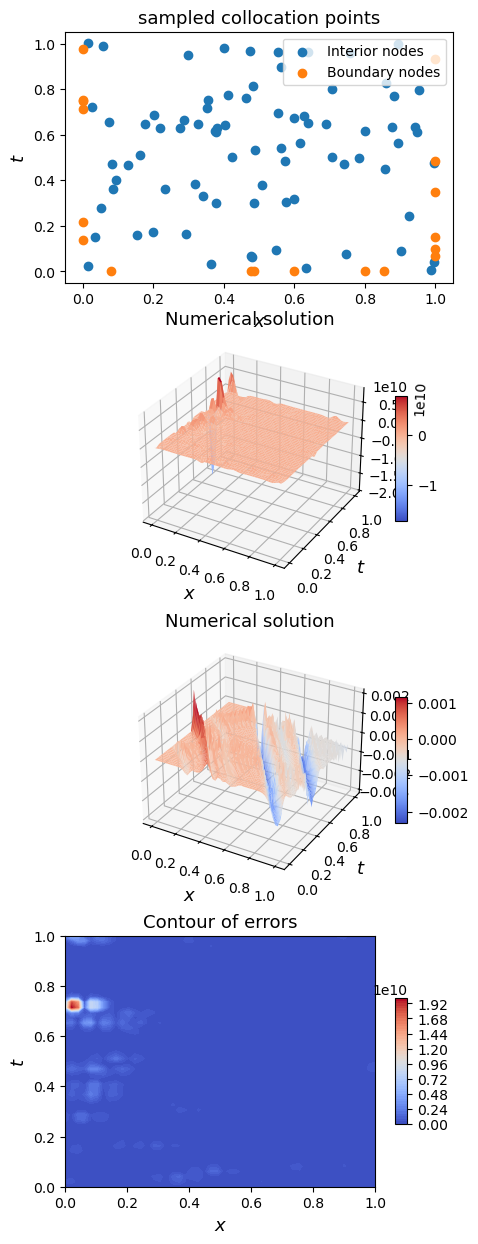

sigma = [50, 20] , nugget = 1e-05 , # pts:  98 
 space-time L2 error:  861506826.9737868 , max err:  19774273873.948177


<Figure size 1500x500 with 0 Axes>

In [39]:
# plot figures
here_fontsize=13

# --------------space time plot---------------------
fig = plt.figure(figsize=(5,15))

ax = fig.add_subplot(411)
ax.scatter(X_domain_tot[range(N_domain_tot), 1], X_domain_tot[range(N_domain_tot), 0], label='Interior nodes')
ax.scatter(X_boundary_tot[range(N_boundary_tot), 1], X_boundary_tot[range(N_boundary_tot), 0], label='Boundary nodes')
ax.legend(loc="upper right")
plt.title('sampled collocation points', fontsize=here_fontsize)
plt.xlabel('$x$', fontsize=here_fontsize)
plt.ylabel('$t$', fontsize=here_fontsize) 

# plot the numerical solution
ax = fig.add_subplot(412, projection='3d')
u_sol_surf=ax.plot_surface(YY, XX, extended_u, cmap=plt.cm.coolwarm)
plt.xlabel('$x$', fontsize=here_fontsize)
plt.ylabel('$t$', fontsize=here_fontsize) 
plt.title('Numerical solution', fontsize=here_fontsize)
fig.colorbar(u_sol_surf, shrink= 0.5, aspect = 10)

# plot the numerical solution
ax = fig.add_subplot(413, projection='3d')
u_sol_surf=ax.plot_surface(YY, XX, u_truth, cmap=plt.cm.coolwarm)
plt.xlabel('$x$', fontsize=here_fontsize)
plt.ylabel('$t$', fontsize=here_fontsize) 
plt.title('Numerical solution', fontsize=here_fontsize)
fig.colorbar(u_sol_surf, shrink= 0.5, aspect = 10)

# contourf
ax = fig.add_subplot(414)
u_contourf=ax.contourf(YY, XX, abs(extended_u-u_truth), 50, cmap=plt.cm.coolwarm)
plt.xlabel('$x$', fontsize=here_fontsize)
plt.ylabel('$t$', fontsize=here_fontsize)
plt.title('Contour of errors', fontsize=here_fontsize)
fig.colorbar(u_contourf, shrink= 0.5, aspect = 10)

fig.savefig('Burgers_pts1500_sol_contour_plt.pdf', bbox_inches='tight',dpi=100,pad_inches=0.1)

plt.show()
fig.tight_layout()

fig.savefig('Burgers_pts1500_sol_contour_plt.pdf', bbox_inches='tight',dpi=100,pad_inches=0.1)

print('sigma =', set_sigma, ', nugget =', set_nugget, ', # pts: ', N_domain_tot+N_boundary_tot, '\n space-time L2 error: ', space_time_L2err, ', max err: ', space_time_Maxerr)

# ---------------time slice plot--------------------
fig = plt.figure(figsize=(15,5))

plt.show()
fig.tight_layout()



In [36]:
print(space_time_L2err)
print(space_time_Maxerr)

861506826.9737868
19774273873.948177
